In [3]:
!pip3 install --user tensorflow=='2.0.0a0'
!pip3 install sklearn

    0% |                                | 184kB 12.0MB/s eta 0:00:07

    1% |▋                               | 1.5MB 44.7MB/s eta 0:00:02

    4% |█▋                              | 3.9MB 53.4MB/s eta 0:00:02

    8% |██▋                             | 6.5MB 48.7MB/s eta 0:00:02

    9% |███▏                            | 8.0MB 59.2MB/s eta 0:00:02

    12% |███▉                            | 9.7MB 42.2MB/s eta 0:00:02

    15% |████▉                           | 12.2MB 52.6MB/s eta 0:00:02

    18% |██████                          | 14.9MB 50.1MB/s eta 0:00:02

    21% |███████                         | 17.5MB 52.5MB/s eta 0:00:02

    24% |████████                        | 20.0MB 51.6MB/s eta 0:00:02

    28% |█████████                       | 22.7MB 52.7MB/s eta 0:00:02

    31% |██████████▏                     | 25.6MB 63.8MB/s eta 0:00:01

    35% |███████████▎                    | 28.3MB 56.8MB/s eta 0:00:01

    38% |████████████▎                   | 30.9MB 51.4MB/s eta 0:00:01

    41% |█████████████▍                  | 33.6MB 54.3MB/s eta 0:00:01

    45% |██████████████▍                 | 36.2MB 53.3MB/s eta 0:00:01

    48% |███████████████▌                | 39.0MB 55.9MB/s eta 0:00:01

    51% |████████████████▋               | 41.7MB 53.5MB/s eta 0:00:01

    55% |█████████████████▊              | 44.6MB 60.5MB/s eta 0:00:01

    58% |██████████████████▉             | 47.2MB 48.1MB/s eta 0:00:01

    62% |████████████████████            | 50.0MB 42.7MB/s eta 0:00:01

    65% |█████████████████████           | 52.7MB 52.5MB/s eta 0:00:01

    68% |██████████████████████          | 55.4MB 55.4MB/s eta 0:00:01

    72% |███████████████████████▏        | 58.1MB 54.8MB/s eta 0:00:01

    75% |████████████████████████▏       | 60.8MB 35.1MB/s eta 0:00:01

    79% |█████████████████████████▍      | 63.7MB 61.3MB/s eta 0:00:01

    82% |██████████████████████████▎     | 65.9MB 45.6MB/s eta 0:00:01

    85% |███████████████████████████▍    | 68.6MB 59.5MB/s eta 0:00:01

    88% |████████████████████████████▎   | 71.1MB 48.9MB/s eta 0:00:01

    91% |█████████████████████████████▎  | 73.6MB 49.9MB/s eta 0:00:01

    94% |██████████████████████████████▎ | 76.0MB 52.2MB/s eta 0:00:01

    98% |███████████████████████████████▍| 78.9MB 57.6MB/s eta 0:00:01

    99% |████████████████████████████████| 80.3MB 63.8MB/s eta 0:00:01

    100% |████████████████████████████████| 80.3MB 805kB/s 


    100% |████████████████████████████████| 419kB 36.6MB/s 


    78% |█████████████████████████▎      | 2.4MB 59.3MB/s eta 0:00:01

    100% |████████████████████████████████| 3.0MB 18.3MB/s 


  The script tensorboard is installed in '/projects/341a0351-4bbd-47c1-8335-2e7aa1ce9900/.sage//local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Found existing installation: tensorflow 1.14.0


    Uninstalling tensorflow-1.14.0:


      Successfully uninstalled tensorflow-1.14.0


  The scripts freeze_graph, saved_model_cli, tensorboard, tf_upgrade_v2, tflite_convert, toco and toco_from_protos are installed in '/projects/341a0351-4bbd-47c1-8335-2e7aa1ce9900/.sage//local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import joblib

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, classification_report

np.random.seed(seed=17)

In [3]:
# Import simulation results
results = pd.read_csv('processed_results_summary.csv', keep_default_na=False)
results.head()

,Unnamed: 0,Simulation no#,Line,Load,Wind1,Wind2,Wind3,flag,Sequence,n_failures,t_fail,t_first_fail,dt_fail,failed component_type,failed_component_type,cascade,fail
0,0,1,Line 04 - 05,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
1,18,10,Line 26 - 28,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
2,198,100,Line 09 - 39,0.7,0.0,0.0,0.4,0,[],0,,,,,,False,False
3,1998,1000,Line 22 - 23,0.7,0.0,0.8,1.0,0,[],0,,,,,,False,False
4,19998,10000,Line 10 - 11,0.8,0.4,0.2,0.0,0,[],0,,,,,,False,False


### Data Generator

- Create a data generator to read in training, validation and test data by batches
- Model input formats:  
    x -> (batch_size, n_time_steps, n_features)  
    y -> (batch_size, 1)

In [4]:
DATA_PATH = '/output/02_preprocessed_numpy'
files = os.listdir(DATA_PATH)

In [5]:
# Get the simulation ids of sims with and without failures
fail_ids = results[results['flag']==1]['Simulation no#'].tolist()
non_fail_ids = results[results['flag']==0]['Simulation no#'].tolist()

# Randomly select fail and non-fail ids
fail_ids = np.random.choice(fail_ids, size=len(fail_ids), replace=False)
non_fail_ids = np.random.choice(non_fail_ids, size=20000, replace=False)

# Get full filepaths
paths_fail, paths_non_fail = [], []
labels_fail, labels_non_fail = [], []

for file in files:
    file_id = int(file.split('.pkl')[0])

    if file_id in fail_ids and len(paths_fail) < 3500:
        paths_fail.append(os.path.join(DATA_PATH, file))
        labels_fail.append(1)

    if file_id in non_fail_ids and len(paths_non_fail) < 3500:
        paths_non_fail.append(os.path.join(DATA_PATH, file))
        labels_non_fail.append(0)

print(len(paths_fail), len(paths_non_fail))
filepaths, labels = [None]*7000, [None]*7000
filepaths[::2], labels[::2] = paths_fail, labels_fail
filepaths[1::2], labels[1::2] = paths_non_fail, labels_non_fail

train_paths, train_labels = filepaths[:6000], labels[:6000]
val_paths, val_labels = filepaths[6000:6500], labels[6000:6500]
test_paths, test_labels = filepaths[6500:], labels[6500:]

3500 3500


In [6]:
def data_generator_logistic(batch_size, filepaths, labels, length, shift):
    count = 0
    X, y = [], []

    for file, label in zip(filepaths, labels):
        # Load simulation file as numpy array
        
        arr = joblib.load(os.path.join(DATA_PATH, file))

        # Windowing - create evenly sized samples
        end_index = arr.shape[0] - length

        for i in range(0, end_index, shift):
            y.append(int(label))
            X.append(arr[i:(i+length), 1:].flatten())
            count += 1

            if count >= batch_size:
                yield (np.array(X).astype(np.float32), np.array(y))
                X, y = [], []
                count = 0

### Feature importance testing

- read in an example dataframe to see variable names
- permute columns to see the effect on the accuracy 
- do this for both each column in turn and each set of physical components

In [7]:
def permutation_importances(est, X_eval, y_eval, metric):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in range(X_eval.shape[1]):
        save = X_eval[:,col].copy()
        X_eval[:,col] = np.random.permutation(X_eval[:,col])
        m = metric(est, X_eval, y_eval)
        X_eval[:,col] = save
        imp.append(baseline - m)
    return np.array(imp)

def permutation_importances_multi_cols(est, X_eval, y_eval, metric, rem_cols):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    save = X_eval[:,rem_cols].copy()
    X_eval[:,rem_cols] = np.random.permutation(X_eval[:,rem_cols])
    m = metric(est, X_eval, y_eval)
    X_eval[:,rem_cols] = save
    imp.append(baseline - m)
    return np.array(imp)


def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    pred_y = (est.predict(X))
    #pred_y[pred_y >= 0.5] = 1
    #pred_y[pred_y < 0.5] = 0
    acc = (np.sum(y.astype(int)[0] == pred_y.round().astype(int))) / y.shape[0]
    return acc

In [28]:
root_dir = '/data/Data'
def get_list_simulations(root_dir: str):
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            file_list_simulations.append(file)
    return file_list_simulations


def get_dict_scenario_csv(file_list_simulations):
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        simulation_files_dict[int(file_name.split("_")[0])] = file_name
    return simulation_files_dict

def add_NSG_columns_and_sort_columns_alphabetically(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add NSG columns when missing from dataframe in order
    to get homogeneous set of columns in each dataframe.
    """
    cols_to_add = ['NSG_1', 'NSG_1.1', 'NSG_2', 'NSG_3']
    for col in cols_to_add:
        if not col in df.columns:
            df[col] = '0'
    df = df.sort_index(axis=1)
    return df

def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        df[col] = df[col].astype('float')
    return df
def angle_transform(df):
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    generators = ["G 01", "G 02", "G 03", "G 04", "G 05", "G 06", "G 07", "G 08", "G 09", "G 10"]
    for gen in generators: 
        sinangle = np.sin((np.pi/180)*df.loc[:, (gen, "Rotor angle with reference to reference machine angle in deg")])
        cosangle = np.cos((np.pi)*df.loc[:, (gen, "Rotor angle with reference to reference machine angle in deg")])
        columns = df.columns
        sinangleind = columns.get_loc((gen, "Rotor angle with reference to reference machine angle in deg"))
        df = df.drop((gen, "Rotor angle with reference to reference machine angle in deg"), axis = 1)
        df.insert(sinangleind, (gen, "sin of rotor angle"), sinangle)
        df.insert(sinangleind+1, (gen, "cos of rotor angle"), cosangle)
    return df

In [29]:
file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_csv(file_list_simulations)

In [30]:
df = pd.read_csv(os.path.join(root_dir, simulation_files_dict[1]), sep=',', header=[0,1])
df = angle_transform(df)
df = df.drop(['All calculations'], axis =1 )

In [201]:
df.head()

B_L03                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                          1.0               1.00059   
1                          1.0               1.00059   
2                          1.0               1.00059   
3                          1.0               1.00059   
4                          1.0               1.00059   

                         B_L04                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                          1.0               0.99829   
1                          1.0               0.99829   
2                          1.0               0.99829   
3                          1.0               0.99829   
4                          1.0               0.99829   

                         B_L07                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                          1.0              1.001716   
1                          1.0              1.001716   
2                          1.0              1.001716   
3                          1.0              1.001716   
4                          1.0              1.001716   

                         B_L08                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                          1.0              1.000407   
1                          1.0              1.000407   
2                          1.0              1.000407   
3                          1.0              1.000407   
4                          1.0              1.000407   

                         B_L12                        ...  \
  Electrical Frequency in p.u. u1, Magnitude in p.u.  ...   
0                          1.0              0.998207  ...   
1                          1.0              0.998207  ...   
2                          1.0              0.998207  ...   
3                          1.0              0.998207  ...   
4                          1.0              0.998207  ...   

              Trf Load_18             Trf Load_20             Trf Load_21  \
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
0                     2.0                    -1.0                     2.0   
1                     2.0                    -1.0                     2.0   
2                     2.0                    -1.0                     2.0   
3                     2.0                    -1.0                     2.0   
4                     2.0                    -1.0                     2.0   

              Trf Load_23             Trf Load_24             Trf Load_25  \
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
0                     3.0                     4.0                     4.0   
1                     3.0                     4.0                     4.0   
2                     3.0                     4.0                     4.0   
3                     3.0                     4.0                     4.0   
4                     3.0                     4.0                     4.0   

              Trf Load_26             Trf Load_27             Trf Load_28  \
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
0                     4.0                     3.0                     4.0   
1                     4.0                     3.0                     4.0   
2                     4.0                     3.0                     4.0   
3                     4.0                     3.0                     4.0   
4                     4.0                     3.0                     4.0   

              Trf Load_29  
  Tap 1, Current Position  
0                     4.0  
1                     4.0  
2                     4.0  
3                     4.0  
4                     4.0  

[5 rows x 259 columns]

In [32]:
columns = df.columns
print(columns[200:260]);

MultiIndex([('Line 16 - 19', ...),
            ('Line 16 - 19', ...),
            ('Line 16 - 21', ...),
            ('Line 16 - 21', ...),
            ('Line 16 - 21', ...),
            ('Line 16 - 24', ...),
            ('Line 16 - 24', ...),
            ('Line 16 - 24', ...),
            ('Line 17 - 18', ...),
            ('Line 17 - 18', ...),
            ('Line 17 - 18', ...),
            ('Line 17 - 27', ...),
            ('Line 17 - 27', ...),
            ('Line 17 - 27', ...),
            ('Line 21 - 22', ...),
            ('Line 21 - 22', ...),
            ('Line 21 - 22', ...),
            ('Line 22 - 23', ...),
            ('Line 22 - 23', ...),
            ('Line 22 - 23', ...),
            ('Line 23 - 24', ...),
            ('Line 23 - 24', ...),
            ('Line 23 - 24', ...),
            ('Line 25 - 26', ...),
            ('Line 25 - 26', ...),
            ('Line 25 - 26', ...),
            ('Line 26 - 27', ...),
            ('Line 26 - 27', ...),
            ('Line 2

In [236]:
comp_imp = range(73,76)  # get the columns we want from the dataframe (brute force)

In [172]:
def component_importance(df, keys):  # return slices of indices of columns from their keys 
    inds = []                        # keys is a list 
    for key in keys:
        inds.append(df.columns.get_loc(key))
    return inds

In [235]:
#keys = ['G 01', 'G 02', 'G 03', 'G 04','G 05', 'G 06', 'G 07', 'G 08', 'G 09', 'G 10']
keys = ['Bus_NSG_3']
inds = component_importance(df, keys)
#comp_imp = np.r_[inds[0], inds[1], inds[2], inds[3], inds[4], inds[5], inds[6], inds[7],inds[8], inds[9]]
comp_imp = np.r_[inds[0]]
comp_imp

array([75])

In [237]:
permutation_importances_multi_cols(trained_model, test_X[:10000, ], test_y[:10000], accuracy_metric, comp_imp)

array([0.0013])

In [8]:
test_y, test_X = [], []

for X, y in data_generator_logistic(256, test_paths, test_labels, 1, 25):
    test_y.append(y)
    test_X.append(X)
test_y = np.concatenate(test_y)
test_X = np.concatenate(test_X)

In [72]:
#np.sum(test_y[:10].astype(int)[0] == trained_model.predict(test_X[:10, ]).round().astype(int)) / test_y[:10].shape[0]
accuracy_metric(trained_model, test_X[:10, ], test_y[:10])

0.8

In [9]:
n_time_steps = 1
n_feats = 259
model = Sequential()
model.add(Input(shape=(n_time_steps*n_feats,)))
# model.add(LSTM(50, input_shape = (n_time_steps, n_feats)))
model.add(Dense(1, activation = 'sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.load_weights('model_logistic_updated') # Number of time steps and number of features

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 260       
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


In [61]:
test_X[:10, ][0].shape

(259,)

Text(0.5,1,'Weights in the Logistic Regression Model')

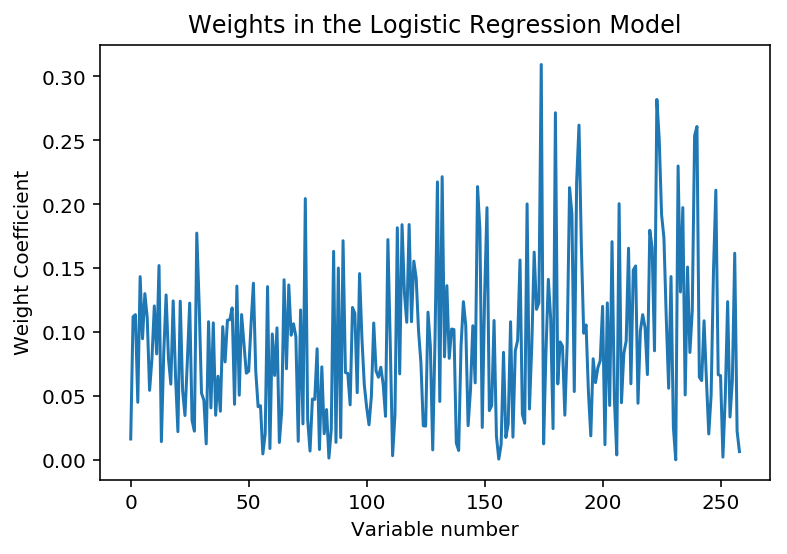

In [44]:
import matplotlib.pyplot as plt
weight = model.get_weights()
plt.plot(np.abs(weight[0]).flatten())
plt.xlabel("Variable number")
plt.ylabel("Weight Coefficient")
plt.title("Weights in the Logistic Regression Model")

In [10]:
#trained_model = tf.keras.models.load_model('model_logistic')
#trained_model = tf.keras.models.load_model('lstm_model')
trained_model = model

In [11]:
#test_X = test_X[:,:,:-2]

In [64]:
#trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [23]:
perm_imp = permutation_importances(trained_model, test_X[:10000, ], test_y[:10000], accuracy_metric)

In [24]:
n = 20
idx = np.argpartition(abs(perm_imp), -n)[-n:]
indices = idx[np.argsort((-abs(perm_imp))[idx])]

In [25]:
perm_imp[indices]

array([-0.0181,  0.0098, -0.0085, -0.0066, -0.0053,  0.0051,  0.004 ,
        0.0033, -0.003 , -0.0028,  0.0026,  0.0025, -0.0025, -0.002 ,
       -0.002 ,  0.0019,  0.0018, -0.0018, -0.0016,  0.0015])

In [41]:
columns[indices][0]
pltlabels = [columns[indices][i][0] for i in range(len(columns[indices]))]

In [42]:
pltlabels

['Line 08 - 09',
 'Line 25 - 26',
 'Line 07 - 08',
 'Line 14 - 15',
 'Line 09 - 39',
 'Line 28 - 29',
 'Line 14 - 15',
 'Line 26 - 29',
 'Line 05 - 08',
 'Line 08 - 09',
 'Line 25 - 26',
 'Line 16 - 24',
 'Line 16 - 19',
 'Line 06 - 07',
 'Line 04 - 05',
 'Line 23 - 24',
 'NSG_2',
 'Line 06 - 11',
 'G 03',
 'Line 01 - 02']

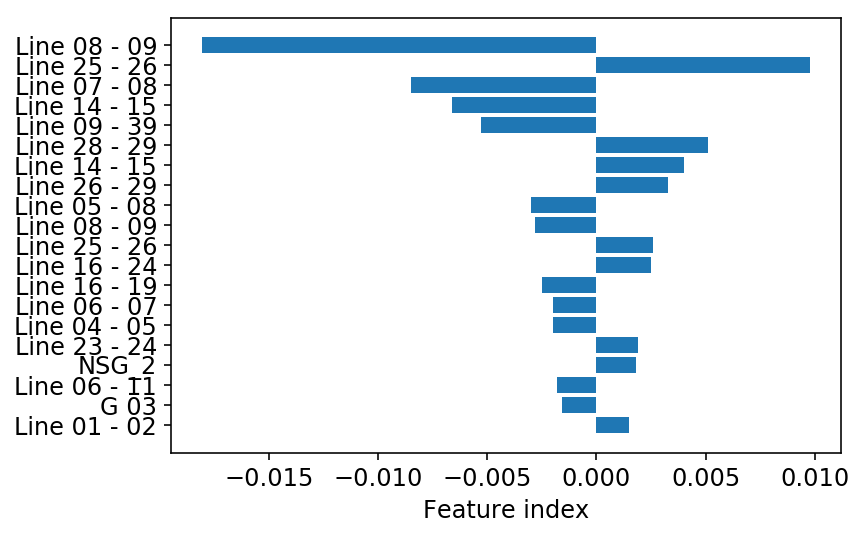

In [48]:
import matplotlib.pyplot as plt
import matplotlib
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 12}
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
y_pos = np.arange(len(perm_imp[indices]))
ax.barh(y_pos, perm_imp[indices], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(pltlabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Change in accurac')
#ax.set_xlim([y_pos[0], y_pos[-1]])
plt.savefig('permutation_feature_importance_logistic_single_col.pdf', dpi=200,bbox_inches='tight')
plt.show()

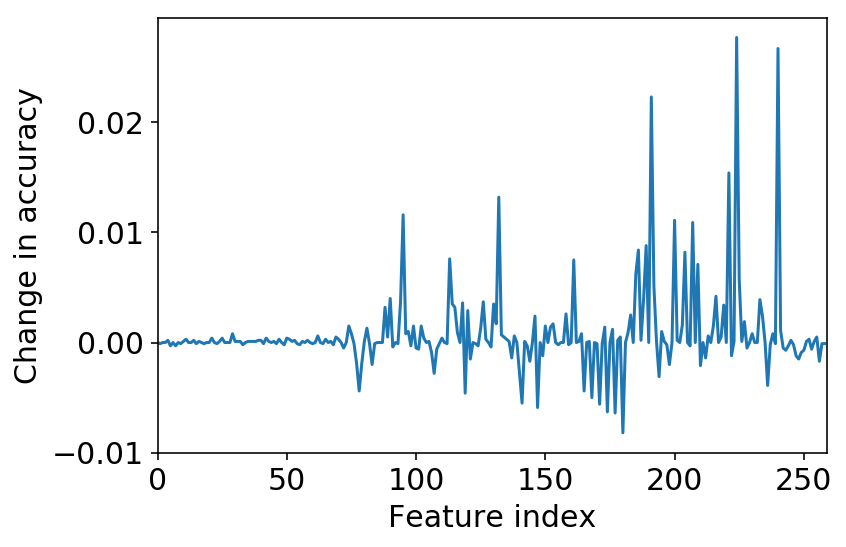

In [120]:
import matplotlib.pyplot as plt
import matplotlib
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 15}
matplotlib.rc('font', **font)
plt.plot(perm_imp)
plt.xlabel("Feature index")
plt.xlim([0,259])
plt.ylabel("Change in accuracy")
plt.savefig('permutation_feature_importance_logistic.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [76]:
test_y.shape

(19968,)

In [32]:
perm_imp;

In [16]:
perm_imp.shape

(259,)

### Model Training and Evaluation
- Train a single layer LSTM model
- Evaluate on test data: accuracy, precision, recall, F1 score

In [20]:
# LSTM
EPOCH_SIZE = 10

# Number of time steps and number of features
n_time_steps = 100
n_feats = 259

model = Sequential()
model.add(LSTM(50, input_shape = (n_time_steps, n_feats)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model.summary()

# Start training
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(
    filepath='checkpoint',
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

model.fit_generator(
    data_generator(256, train_paths, train_labels, 100, 25),
    validation_data=data_generator(256, val_paths, val_labels, 100, 25),
    validation_steps=6,
    epochs=EPOCH_SIZE,
    steps_per_epoch=100,
    callbacks=[early_stop, checkpoint]
)

model.save('model')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_8 (UnifiedLSTM) (None, 50)                62000     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 62,051
Trainable params: 62,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


  1/100 [..............................] - ETA: 3:28 - loss: 0.7416 - accuracy: 0.4375 - precision: 0.0000e+00 - recall: 0.0000e+00

  2/100 [..............................] - ETA: 1:48 - loss: 0.7021 - accuracy: 0.4434 - precision: 0.3832 - recall: 0.1577        

  3/100 [..............................] - ETA: 1:14 - loss: 0.6986 - accuracy: 0.5716 - precision: 0.6558 - recall: 0.3561

  4/100 [>.............................] - ETA: 1:10 - loss: 0.7117 - accuracy: 0.5195 - precision: 0.5357 - recall: 0.4038

  5/100 [>.............................] - ETA: 1:06 - loss: 0.6923 - accuracy: 0.5414 - precision: 0.5501 - recall: 0.5170

  6/100 [>.............................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.5358 - precision: 0.5462 - recall: 0.5077

  7/100 [=>............................] - ETA: 1:03 - loss: 0.6641 - accuracy: 0.5898 - precision: 0.5963 - recall: 0.5678

  8/100 [=>............................] - ETA: 1:01 - loss: 0.6624 - accuracy: 0.5981 - precision: 0.6069 - recall: 0.5923

  9/100 [=>............................] - ETA: 1:00 - loss: 0.6570 - accuracy: 0.6085 - precision: 0.6114 - recall: 0.5955

 10/100 [==>...........................] - ETA: 1:01 - loss: 0.6422 - accuracy: 0.6340 - precision: 0.6458 - recall: 0.6134

 11/100 [==>...........................] - ETA: 1:01 - loss: 0.6329 - accuracy: 0.6534 - precision: 0.6659 - recall: 0.6197

 12/100 [==>...........................] - ETA: 1:00 - loss: 0.6195 - accuracy: 0.6702 - precision: 0.6890 - recall: 0.6298

 13/100 [==>...........................] - ETA: 59s - loss: 0.6049 - accuracy: 0.6932 - precision: 0.7123 - recall: 0.6531 

 14/100 [===>..........................] - ETA: 59s - loss: 0.5893 - accuracy: 0.7048 - precision: 0.7284 - recall: 0.6572

 15/100 [===>..........................] - ETA: 59s - loss: 0.5760 - accuracy: 0.7188 - precision: 0.7457 - recall: 0.6693

 16/100 [===>..........................] - ETA: 59s - loss: 0.5714 - accuracy: 0.7312 - precision: 0.7586 - recall: 0.6798

 17/100 [====>.........................] - ETA: 58s - loss: 0.5689 - accuracy: 0.7325 - precision: 0.7591 - recall: 0.6870

 18/100 [====>.........................] - ETA: 57s - loss: 0.5596 - accuracy: 0.7409 - precision: 0.7611 - recall: 0.7023

 19/100 [====>.........................] - ETA: 57s - loss: 0.5512 - accuracy: 0.7508 - precision: 0.7739 - recall: 0.7132

 20/100 [=====>........................] - ETA: 56s - loss: 0.5391 - accuracy: 0.7631 - precision: 0.7847 - recall: 0.7262

 21/100 [=====>........................] - ETA: 55s - loss: 0.5353 - accuracy: 0.7625 - precision: 0.7765 - recall: 0.7400

 22/100 [=====>........................] - ETA: 54s - loss: 0.5281 - accuracy: 0.7667 - precision: 0.7766 - recall: 0.7507

 23/100 [=====>........................] - ETA: 54s - loss: 0.5263 - accuracy: 0.7697 - precision: 0.7832 - recall: 0.7476

 24/100 [======>.......................] - ETA: 53s - loss: 0.5172 - accuracy: 0.7747 - precision: 0.7909 - recall: 0.7494

 25/100 [======>.......................] - ETA: 53s - loss: 0.5106 - accuracy: 0.7789 - precision: 0.7911 - recall: 0.7587

 26/100 [======>.......................] - ETA: 53s - loss: 0.5072 - accuracy: 0.7814 - precision: 0.7977 - recall: 0.7569

 27/100 [=======>......................] - ETA: 52s - loss: 0.4998 - accuracy: 0.7867 - precision: 0.8034 - recall: 0.7593

 28/100 [=======>......................] - ETA: 51s - loss: 0.4960 - accuracy: 0.7896 - precision: 0.8098 - recall: 0.7594

 29/100 [=======>......................] - ETA: 51s - loss: 0.4911 - accuracy: 0.7967 - precision: 0.8161 - recall: 0.7667

 30/100 [========>.....................] - ETA: 50s - loss: 0.4900 - accuracy: 0.7982 - precision: 0.8210 - recall: 0.7643

 31/100 [========>.....................] - ETA: 49s - loss: 0.4915 - accuracy: 0.7960 - precision: 0.8237 - recall: 0.7543

 32/100 [========>.....................] - ETA: 48s - loss: 0.4878 - accuracy: 0.7992 - precision: 0.8285 - recall: 0.7556

 33/100 [========>.....................] - ETA: 48s - loss: 0.4855 - accuracy: 0.8013 - precision: 0.8318 - recall: 0.7566

 34/100 [=========>....................] - ETA: 47s - loss: 0.4810 - accuracy: 0.8066 - precision: 0.8367 - recall: 0.7624

 35/100 [=========>....................] - ETA: 46s - loss: 0.4746 - accuracy: 0.8122 - precision: 0.8423 - recall: 0.7698

 36/100 [=========>....................] - ETA: 46s - loss: 0.4712 - accuracy: 0.8136 - precision: 0.8452 - recall: 0.7678

 37/100 [==========>...................] - ETA: 45s - loss: 0.4659 - accuracy: 0.8186 - precision: 0.8503 - recall: 0.7748

 38/100 [==========>...................] - ETA: 44s - loss: 0.4614 - accuracy: 0.8200 - precision: 0.8530 - recall: 0.7736

 39/100 [==========>...................] - ETA: 44s - loss: 0.4563 - accuracy: 0.8245 - precision: 0.8572 - recall: 0.7798

 40/100 [===========>..................] - ETA: 43s - loss: 0.4509 - accuracy: 0.8289 - precision: 0.8610 - recall: 0.7851

 41/100 [===========>..................] - ETA: 42s - loss: 0.4432 - accuracy: 0.8331 - precision: 0.8647 - recall: 0.7903

 42/100 [===========>..................] - ETA: 41s - loss: 0.4377 - accuracy: 0.8369 - precision: 0.8683 - recall: 0.7951

 43/100 [===========>..................] - ETA: 41s - loss: 0.4339 - accuracy: 0.8407 - precision: 0.8714 - recall: 0.7996

 44/100 [============>.................] - ETA: 40s - loss: 0.4317 - accuracy: 0.8407 - precision: 0.8734 - recall: 0.7980

 45/100 [============>.................] - ETA: 39s - loss: 0.4262 - accuracy: 0.8438 - precision: 0.8760 - recall: 0.8010

 46/100 [============>.................] - ETA: 39s - loss: 0.4245 - accuracy: 0.8438 - precision: 0.8784 - recall: 0.7991

 47/100 [=============>................] - ETA: 38s - loss: 0.4209 - accuracy: 0.8470 - precision: 0.8809 - recall: 0.8027

 48/100 [=============>................] - ETA: 37s - loss: 0.4192 - accuracy: 0.8470 - precision: 0.8806 - recall: 0.8036

 49/100 [=============>................] - ETA: 37s - loss: 0.4209 - accuracy: 0.8430 - precision: 0.8697 - recall: 0.8075

 50/100 [==============>...............] - ETA: 36s - loss: 0.4164 - accuracy: 0.8458 - precision: 0.8721 - recall: 0.8109

 51/100 [==============>...............] - ETA: 35s - loss: 0.4127 - accuracy: 0.8484 - precision: 0.8743 - recall: 0.8145

 52/100 [==============>...............] - ETA: 34s - loss: 0.4094 - accuracy: 0.8513 - precision: 0.8766 - recall: 0.8179

 53/100 [==============>...............] - ETA: 34s - loss: 0.4050 - accuracy: 0.8541 - precision: 0.8793 - recall: 0.8216

 54/100 [===============>..............] - ETA: 33s - loss: 0.4022 - accuracy: 0.8567 - precision: 0.8814 - recall: 0.8244

 55/100 [===============>..............] - ETA: 32s - loss: 0.4015 - accuracy: 0.8555 - precision: 0.8830 - recall: 0.8204

 56/100 [===============>..............] - ETA: 32s - loss: 0.3981 - accuracy: 0.8571 - precision: 0.8848 - recall: 0.8214

 57/100 [================>.............] - ETA: 31s - loss: 0.3964 - accuracy: 0.8576 - precision: 0.8866 - recall: 0.8206

 58/100 [================>.............] - ETA: 30s - loss: 0.3925 - accuracy: 0.8595 - precision: 0.8885 - recall: 0.8225

 59/100 [================>.............] - ETA: 29s - loss: 0.3890 - accuracy: 0.8619 - precision: 0.8906 - recall: 0.8255

 60/100 [=================>............] - ETA: 29s - loss: 0.3852 - accuracy: 0.8638 - precision: 0.8925 - recall: 0.8277

 61/100 [=================>............] - ETA: 28s - loss: 0.3807 - accuracy: 0.8660 - precision: 0.8943 - recall: 0.8303

 62/100 [=================>............] - ETA: 27s - loss: 0.3771 - accuracy: 0.8681 - precision: 0.8963 - recall: 0.8332

 63/100 [=================>............] - ETA: 27s - loss: 0.3730 - accuracy: 0.8702 - precision: 0.8978 - recall: 0.8356

 64/100 [==================>...........] - ETA: 26s - loss: 0.3701 - accuracy: 0.8721 - precision: 0.8997 - recall: 0.8382

 65/100 [==================>...........] - ETA: 25s - loss: 0.3666 - accuracy: 0.8740 - precision: 0.9012 - recall: 0.8403

 66/100 [==================>...........] - ETA: 25s - loss: 0.3632 - accuracy: 0.8758 - precision: 0.9027 - recall: 0.8429

 67/100 [===================>..........] - ETA: 24s - loss: 0.3595 - accuracy: 0.8776 - precision: 0.9042 - recall: 0.8451

 68/100 [===================>..........] - ETA: 23s - loss: 0.3561 - accuracy: 0.8793 - precision: 0.9056 - recall: 0.8471

 69/100 [===================>..........] - ETA: 23s - loss: 0.3527 - accuracy: 0.8805 - precision: 0.9070 - recall: 0.8483

 70/100 [====================>.........] - ETA: 22s - loss: 0.3495 - accuracy: 0.8820 - precision: 0.9082 - recall: 0.8501

 71/100 [====================>.........] - ETA: 21s - loss: 0.3459 - accuracy: 0.8836 - precision: 0.9097 - recall: 0.8523

 72/100 [====================>.........] - ETA: 20s - loss: 0.3422 - accuracy: 0.8853 - precision: 0.9109 - recall: 0.8541

 73/100 [====================>.........] - ETA: 20s - loss: 0.3414 - accuracy: 0.8855 - precision: 0.9121 - recall: 0.8537

 74/100 [=====================>........] - ETA: 19s - loss: 0.3404 - accuracy: 0.8852 - precision: 0.9128 - recall: 0.8518

 75/100 [=====================>........] - ETA: 18s - loss: 0.3381 - accuracy: 0.8867 - precision: 0.9141 - recall: 0.8539

 76/100 [=====================>........] - ETA: 17s - loss: 0.3369 - accuracy: 0.8864 - precision: 0.9119 - recall: 0.8557

 77/100 [======================>.......] - ETA: 17s - loss: 0.3341 - accuracy: 0.8879 - precision: 0.9131 - recall: 0.8576

 78/100 [======================>.......] - ETA: 16s - loss: 0.3321 - accuracy: 0.8892 - precision: 0.9143 - recall: 0.8591

 79/100 [======================>.......] - ETA: 15s - loss: 0.3302 - accuracy: 0.8904 - precision: 0.9150 - recall: 0.8608

 80/100 [=======================>......] - ETA: 14s - loss: 0.3271 - accuracy: 0.8917 - precision: 0.9162 - recall: 0.8627

 81/100 [=======================>......] - ETA: 14s - loss: 0.3255 - accuracy: 0.8930 - precision: 0.9171 - recall: 0.8642

 82/100 [=======================>......] - ETA: 13s - loss: 0.3223 - accuracy: 0.8943 - precision: 0.9183 - recall: 0.8661

 83/100 [=======================>......] - ETA: 12s - loss: 0.3202 - accuracy: 0.8954 - precision: 0.9192 - recall: 0.8671

 84/100 [========================>.....] - ETA: 12s - loss: 0.3203 - accuracy: 0.8949 - precision: 0.9200 - recall: 0.8653

 85/100 [========================>.....] - ETA: 11s - loss: 0.3179 - accuracy: 0.8960 - precision: 0.9209 - recall: 0.8666

 86/100 [========================>.....] - ETA: 10s - loss: 0.3154 - accuracy: 0.8971 - precision: 0.9219 - recall: 0.8679

 87/100 [=========================>....] - ETA: 9s - loss: 0.3125 - accuracy: 0.8983 - precision: 0.9229 - recall: 0.8694 

 88/100 [=========================>....] - ETA: 8s - loss: 0.3105 - accuracy: 0.8993 - precision: 0.9237 - recall: 0.8706

 89/100 [=========================>....] - ETA: 8s - loss: 0.3079 - accuracy: 0.9002 - precision: 0.9243 - recall: 0.8722

 90/100 [==========================>...] - ETA: 7s - loss: 0.3053 - accuracy: 0.9013 - precision: 0.9251 - recall: 0.8734

 91/100 [==========================>...] - ETA: 6s - loss: 0.3031 - accuracy: 0.9023 - precision: 0.9260 - recall: 0.8749

 92/100 [==========================>...] - ETA: 5s - loss: 0.3026 - accuracy: 0.9019 - precision: 0.9237 - recall: 0.8761

 93/100 [==========================>...] - ETA: 5s - loss: 0.3000 - accuracy: 0.9029 - precision: 0.9247 - recall: 0.8775

 94/100 [===========================>..] - ETA: 4s - loss: 0.2974 - accuracy: 0.9039 - precision: 0.9255 - recall: 0.8787

 95/100 [===========================>..] - ETA: 3s - loss: 0.2947 - accuracy: 0.9049 - precision: 0.9263 - recall: 0.8800

 96/100 [===========================>..] - ETA: 2s - loss: 0.2927 - accuracy: 0.9059 - precision: 0.9271 - recall: 0.8813

 97/100 [============================>.] - ETA: 2s - loss: 0.2906 - accuracy: 0.9069 - precision: 0.9279 - recall: 0.8824

 98/100 [============================>.] - ETA: 1s - loss: 0.2886 - accuracy: 0.9078 - precision: 0.9287 - recall: 0.8838

 99/100 [============================>.] - ETA: 0s - loss: 0.2865 - accuracy: 0.9087 - precision: 0.9294 - recall: 0.8845

100/100 [==============================] - 81s 813ms/step - loss: 0.2841 - accuracy: 0.9096 - precision: 0.9302 - recall: 0.8858 - val_loss: 0.7708 - val_accuracy: 0.6107 - val_precision: 0.5748 - val_recall: 0.8962


Epoch 2/10
  1/100 [..............................] - ETA: 8s - loss: 0.0834 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  2/100 [..............................] - ETA: 8s - loss: 0.0669 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  3/100 [..............................] - ETA: 8s - loss: 0.1034 - accuracy: 0.9531 - precision: 0.9126 - recall: 1.0000

  4/100 [>.............................] - ETA: 8s - loss: 0.0921 - accuracy: 0.9619 - precision: 0.9330 - recall: 0.9940

  5/100 [>.............................] - ETA: 8s - loss: 0.0862 - accuracy: 0.9664 - precision: 0.9459 - recall: 0.9890

  6/100 [>.............................] - ETA: 8s - loss: 0.0784 - accuracy: 0.9720 - precision: 0.9541 - recall: 0.9907

  7/100 [=>............................] - ETA: 8s - loss: 0.0731 - accuracy: 0.9760 - precision: 0.9611 - recall: 0.9922

  8/100 [=>............................] - ETA: 15s - loss: 0.0936 - accuracy: 0.9663 - precision: 0.9644 - recall: 0.9673

  9/100 [=>............................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9701 - precision: 0.9688 - recall: 0.9714

 10/100 [==>...........................] - ETA: 26s - loss: 0.0848 - accuracy: 0.9727 - precision: 0.9717 - recall: 0.9732

 11/100 [==>...........................] - ETA: 31s - loss: 0.0826 - accuracy: 0.9741 - precision: 0.9743 - recall: 0.9736

 12/100 [==>...........................] - ETA: 34s - loss: 0.0803 - accuracy: 0.9762 - precision: 0.9764 - recall: 0.9758

 13/100 [==>...........................] - ETA: 37s - loss: 0.0804 - accuracy: 0.9781 - precision: 0.9782 - recall: 0.9777

 14/100 [===>..........................] - ETA: 39s - loss: 0.0777 - accuracy: 0.9796 - precision: 0.9799 - recall: 0.9793

 15/100 [===>..........................] - ETA: 41s - loss: 0.0761 - accuracy: 0.9810 - precision: 0.9811 - recall: 0.9806

 16/100 [===>..........................] - ETA: 42s - loss: 0.0779 - accuracy: 0.9822 - precision: 0.9824 - recall: 0.9819

 17/100 [====>.........................] - ETA: 43s - loss: 0.0763 - accuracy: 0.9832 - precision: 0.9833 - recall: 0.9829

 18/100 [====>.........................] - ETA: 44s - loss: 0.0839 - accuracy: 0.9768 - precision: 0.9700 - recall: 0.9839

 19/100 [====>.........................] - ETA: 44s - loss: 0.0826 - accuracy: 0.9780 - precision: 0.9715 - recall: 0.9847

 20/100 [=====>........................] - ETA: 45s - loss: 0.0847 - accuracy: 0.9789 - precision: 0.9730 - recall: 0.9851

 21/100 [=====>........................] - ETA: 45s - loss: 0.0845 - accuracy: 0.9790 - precision: 0.9741 - recall: 0.9840

 22/100 [=====>........................] - ETA: 45s - loss: 0.0835 - accuracy: 0.9798 - precision: 0.9753 - recall: 0.9843

 23/100 [=====>........................] - ETA: 45s - loss: 0.0883 - accuracy: 0.9744 - precision: 0.9650 - recall: 0.9844

 24/100 [======>.......................] - ETA: 45s - loss: 0.0867 - accuracy: 0.9754 - precision: 0.9663 - recall: 0.9850

 25/100 [======>.......................] - ETA: 45s - loss: 0.0849 - accuracy: 0.9764 - precision: 0.9678 - recall: 0.9856

 26/100 [======>.......................] - ETA: 45s - loss: 0.0834 - accuracy: 0.9773 - precision: 0.9689 - recall: 0.9861

 27/100 [=======>......................] - ETA: 45s - loss: 0.0840 - accuracy: 0.9782 - precision: 0.9701 - recall: 0.9867

 28/100 [=======>......................] - ETA: 45s - loss: 0.0834 - accuracy: 0.9787 - precision: 0.9711 - recall: 0.9866

 29/100 [=======>......................] - ETA: 45s - loss: 0.0819 - accuracy: 0.9794 - precision: 0.9721 - recall: 0.9871

 30/100 [========>.....................] - ETA: 44s - loss: 0.0801 - accuracy: 0.9801 - precision: 0.9730 - recall: 0.9875

 31/100 [========>.....................] - ETA: 44s - loss: 0.0784 - accuracy: 0.9807 - precision: 0.9739 - recall: 0.9879

 32/100 [========>.....................] - ETA: 43s - loss: 0.0781 - accuracy: 0.9812 - precision: 0.9745 - recall: 0.9883

 33/100 [========>.....................] - ETA: 43s - loss: 0.0764 - accuracy: 0.9818 - precision: 0.9752 - recall: 0.9886

 34/100 [=========>....................] - ETA: 43s - loss: 0.0747 - accuracy: 0.9823 - precision: 0.9760 - recall: 0.9890

 35/100 [=========>....................] - ETA: 43s - loss: 0.0738 - accuracy: 0.9827 - precision: 0.9766 - recall: 0.9890

 36/100 [=========>....................] - ETA: 43s - loss: 0.0793 - accuracy: 0.9794 - precision: 0.9771 - recall: 0.9818

 37/100 [==========>...................] - ETA: 42s - loss: 0.0790 - accuracy: 0.9798 - precision: 0.9777 - recall: 0.9820

 38/100 [==========>...................] - ETA: 42s - loss: 0.0912 - accuracy: 0.9716 - precision: 0.9617 - recall: 0.9823

 39/100 [==========>...................] - ETA: 41s - loss: 0.1065 - accuracy: 0.9616 - precision: 0.9428 - recall: 0.9827

 40/100 [===========>..................] - ETA: 41s - loss: 0.1081 - accuracy: 0.9623 - precision: 0.9437 - recall: 0.9832

 41/100 [===========>..................] - ETA: 40s - loss: 0.1097 - accuracy: 0.9618 - precision: 0.9424 - recall: 0.9836

 42/100 [===========>..................] - ETA: 40s - loss: 0.1189 - accuracy: 0.9560 - precision: 0.9372 - recall: 0.9773

 43/100 [===========>..................] - ETA: 40s - loss: 0.1192 - accuracy: 0.9568 - precision: 0.9387 - recall: 0.9773

 44/100 [============>.................] - ETA: 39s - loss: 0.1254 - accuracy: 0.9543 - precision: 0.9395 - recall: 0.9708

 45/100 [============>.................] - ETA: 39s - loss: 0.1353 - accuracy: 0.9463 - precision: 0.9399 - recall: 0.9535

 46/100 [============>.................] - ETA: 39s - loss: 0.1422 - accuracy: 0.9435 - precision: 0.9406 - recall: 0.9466

 47/100 [=============>................] - ETA: 38s - loss: 0.1592 - accuracy: 0.9358 - precision: 0.9409 - recall: 0.9300

 48/100 [=============>................] - ETA: 38s - loss: 0.1627 - accuracy: 0.9333 - precision: 0.9417 - recall: 0.9237

 49/100 [=============>................] - ETA: 37s - loss: 0.1652 - accuracy: 0.9334 - precision: 0.9427 - recall: 0.9227

 50/100 [==============>...............] - ETA: 37s - loss: 0.1676 - accuracy: 0.9320 - precision: 0.9436 - recall: 0.9187

 51/100 [==============>...............] - ETA: 36s - loss: 0.1690 - accuracy: 0.9331 - precision: 0.9443 - recall: 0.9202

 52/100 [==============>...............] - ETA: 36s - loss: 0.1730 - accuracy: 0.9320 - precision: 0.9451 - recall: 0.9174

 53/100 [==============>...............] - ETA: 35s - loss: 0.1799 - accuracy: 0.9306 - precision: 0.9408 - recall: 0.9186

 54/100 [===============>..............] - ETA: 35s - loss: 0.1820 - accuracy: 0.9300 - precision: 0.9385 - recall: 0.9203

 55/100 [===============>..............] - ETA: 34s - loss: 0.1879 - accuracy: 0.9284 - precision: 0.9341 - recall: 0.9216

 56/100 [===============>..............] - ETA: 34s - loss: 0.1884 - accuracy: 0.9297 - precision: 0.9354 - recall: 0.9231

 57/100 [================>.............] - ETA: 33s - loss: 0.1940 - accuracy: 0.9265 - precision: 0.9315 - recall: 0.9206

 58/100 [================>.............] - ETA: 32s - loss: 0.1969 - accuracy: 0.9241 - precision: 0.9322 - recall: 0.9145

 59/100 [================>.............] - ETA: 32s - loss: 0.1996 - accuracy: 0.9243 - precision: 0.9333 - recall: 0.9139

 60/100 [=================>............] - ETA: 31s - loss: 0.2011 - accuracy: 0.9232 - precision: 0.9340 - recall: 0.9105

 61/100 [=================>............] - ETA: 31s - loss: 0.2047 - accuracy: 0.9217 - precision: 0.9308 - recall: 0.9111

 62/100 [=================>............] - ETA: 30s - loss: 0.2063 - accuracy: 0.9207 - precision: 0.9315 - recall: 0.9078

 63/100 [=================>............] - ETA: 29s - loss: 0.2079 - accuracy: 0.9216 - precision: 0.9325 - recall: 0.9091

 64/100 [==================>...........] - ETA: 29s - loss: 0.2088 - accuracy: 0.9227 - precision: 0.9333 - recall: 0.9103

 65/100 [==================>...........] - ETA: 28s - loss: 0.2098 - accuracy: 0.9238 - precision: 0.9344 - recall: 0.9115

 66/100 [==================>...........] - ETA: 27s - loss: 0.2095 - accuracy: 0.9250 - precision: 0.9354 - recall: 0.9128

 67/100 [===================>..........] - ETA: 26s - loss: 0.2128 - accuracy: 0.9236 - precision: 0.9322 - recall: 0.9134

 68/100 [===================>..........] - ETA: 25s - loss: 0.2151 - accuracy: 0.9206 - precision: 0.9327 - recall: 0.9066

 69/100 [===================>..........] - ETA: 25s - loss: 0.2167 - accuracy: 0.9212 - precision: 0.9336 - recall: 0.9067

 70/100 [====================>.........] - ETA: 24s - loss: 0.2190 - accuracy: 0.9184 - precision: 0.9341 - recall: 0.9002

 71/100 [====================>.........] - ETA: 23s - loss: 0.2192 - accuracy: 0.9193 - precision: 0.9349 - recall: 0.9010

 72/100 [====================>.........] - ETA: 22s - loss: 0.2189 - accuracy: 0.9200 - precision: 0.9359 - recall: 0.9017

 73/100 [====================>.........] - ETA: 22s - loss: 0.2181 - accuracy: 0.9209 - precision: 0.9367 - recall: 0.9026

 74/100 [=====================>........] - ETA: 21s - loss: 0.2173 - accuracy: 0.9218 - precision: 0.9376 - recall: 0.9036

 75/100 [=====================>........] - ETA: 20s - loss: 0.2160 - accuracy: 0.9228 - precision: 0.9385 - recall: 0.9047

 76/100 [=====================>........] - ETA: 19s - loss: 0.2146 - accuracy: 0.9237 - precision: 0.9393 - recall: 0.9059

 77/100 [======================>.......] - ETA: 18s - loss: 0.2145 - accuracy: 0.9242 - precision: 0.9401 - recall: 0.9061

 78/100 [======================>.......] - ETA: 18s - loss: 0.2143 - accuracy: 0.9249 - precision: 0.9408 - recall: 0.9067

 79/100 [======================>.......] - ETA: 17s - loss: 0.2133 - accuracy: 0.9257 - precision: 0.9416 - recall: 0.9077

 80/100 [=======================>......] - ETA: 16s - loss: 0.2123 - accuracy: 0.9265 - precision: 0.9423 - recall: 0.9084

 81/100 [=======================>......] - ETA: 15s - loss: 0.2115 - accuracy: 0.9272 - precision: 0.9431 - recall: 0.9093

 82/100 [=======================>......] - ETA: 15s - loss: 0.2107 - accuracy: 0.9278 - precision: 0.9431 - recall: 0.9103

 83/100 [=======================>......] - ETA: 14s - loss: 0.2094 - accuracy: 0.9287 - precision: 0.9438 - recall: 0.9115

 84/100 [========================>.....] - ETA: 13s - loss: 0.2082 - accuracy: 0.9294 - precision: 0.9445 - recall: 0.9122

 85/100 [========================>.....] - ETA: 12s - loss: 0.2075 - accuracy: 0.9301 - precision: 0.9452 - recall: 0.9132

 86/100 [========================>.....] - ETA: 11s - loss: 0.2063 - accuracy: 0.9310 - precision: 0.9458 - recall: 0.9142

 87/100 [=========================>....] - ETA: 11s - loss: 0.2078 - accuracy: 0.9301 - precision: 0.9463 - recall: 0.9119

 88/100 [=========================>....] - ETA: 10s - loss: 0.2064 - accuracy: 0.9309 - precision: 0.9470 - recall: 0.9130

 89/100 [=========================>....] - ETA: 9s - loss: 0.2052 - accuracy: 0.9317 - precision: 0.9475 - recall: 0.9139 

 90/100 [==========================>...] - ETA: 8s - loss: 0.2041 - accuracy: 0.9325 - precision: 0.9482 - recall: 0.9149

 91/100 [==========================>...] - ETA: 7s - loss: 0.2031 - accuracy: 0.9332 - precision: 0.9487 - recall: 0.9158

 92/100 [==========================>...] - ETA: 6s - loss: 0.2054 - accuracy: 0.9324 - precision: 0.9492 - recall: 0.9136

 93/100 [==========================>...] - ETA: 6s - loss: 0.2080 - accuracy: 0.9302 - precision: 0.9494 - recall: 0.9087

 94/100 [===========================>..] - ETA: 5s - loss: 0.2070 - accuracy: 0.9309 - precision: 0.9500 - recall: 0.9097

 95/100 [===========================>..] - ETA: 4s - loss: 0.2067 - accuracy: 0.9317 - precision: 0.9505 - recall: 0.9107

 96/100 [===========================>..] - ETA: 3s - loss: 0.2063 - accuracy: 0.9322 - precision: 0.9507 - recall: 0.9115

 97/100 [============================>.] - ETA: 2s - loss: 0.2071 - accuracy: 0.9315 - precision: 0.9484 - recall: 0.9125

 98/100 [============================>.] - ETA: 1s - loss: 0.2065 - accuracy: 0.9321 - precision: 0.9488 - recall: 0.9133

 99/100 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9328 - precision: 0.9494 - recall: 0.9143

100/100 [==============================] - 94s 945ms/step - loss: 0.2045 - accuracy: 0.9334 - precision: 0.9498 - recall: 0.9149 - val_loss: 0.2039 - val_accuracy: 0.9616 - val_precision: 0.9418 - val_recall: 0.9845


Epoch 3/10
  1/100 [..............................] - ETA: 8s - loss: 0.0909 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  2/100 [..............................] - ETA: 8s - loss: 0.0896 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  3/100 [..............................] - ETA: 8s - loss: 0.1122 - accuracy: 0.9974 - precision: 1.0000 - recall: 0.9948

  4/100 [>.............................] - ETA: 9s - loss: 0.1155 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.9962

  5/100 [>.............................] - ETA: 9s - loss: 0.1237 - accuracy: 0.9977 - precision: 1.0000 - recall: 0.9953

  6/100 [>.............................] - ETA: 9s - loss: 0.1163 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.9962

  7/100 [=>............................] - ETA: 17s - loss: 0.1409 - accuracy: 0.9821 - precision: 1.0000 - recall: 0.9641

  8/100 [=>............................] - ETA: 25s - loss: 0.1350 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.9691

  9/100 [=>............................] - ETA: 32s - loss: 0.1354 - accuracy: 0.9861 - precision: 1.0000 - recall: 0.9722

 10/100 [==>...........................] - ETA: 37s - loss: 0.1310 - accuracy: 0.9875 - precision: 1.0000 - recall: 0.9752

 11/100 [==>...........................] - ETA: 41s - loss: 0.1321 - accuracy: 0.9865 - precision: 0.9957 - recall: 0.9773

 12/100 [==>...........................] - ETA: 43s - loss: 0.1284 - accuracy: 0.9876 - precision: 0.9960 - recall: 0.9792

 13/100 [==>...........................] - ETA: 46s - loss: 0.1358 - accuracy: 0.9775 - precision: 0.9750 - recall: 0.9803

 14/100 [===>..........................] - ETA: 47s - loss: 0.1326 - accuracy: 0.9788 - precision: 0.9767 - recall: 0.9810

 15/100 [===>..........................] - ETA: 49s - loss: 0.1292 - accuracy: 0.9797 - precision: 0.9783 - recall: 0.9814

 16/100 [===>..........................] - ETA: 51s - loss: 0.1270 - accuracy: 0.9802 - precision: 0.9795 - recall: 0.9809

 17/100 [====>.........................] - ETA: 52s - loss: 0.1258 - accuracy: 0.9809 - precision: 0.9808 - recall: 0.9813

 18/100 [====>.........................] - ETA: 54s - loss: 0.1220 - accuracy: 0.9820 - precision: 0.9818 - recall: 0.9822

 19/100 [====>.........................] - ETA: 54s - loss: 0.1187 - accuracy: 0.9829 - precision: 0.9828 - recall: 0.9832

 20/100 [=====>........................] - ETA: 55s - loss: 0.1155 - accuracy: 0.9838 - precision: 0.9836 - recall: 0.9840

 21/100 [=====>........................] - ETA: 55s - loss: 0.1151 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844

 22/100 [=====>........................] - ETA: 55s - loss: 0.1183 - accuracy: 0.9847 - precision: 0.9851 - recall: 0.9844

 23/100 [=====>........................] - ETA: 55s - loss: 0.1182 - accuracy: 0.9832 - precision: 0.9857 - recall: 0.9806

 24/100 [======>.......................] - ETA: 55s - loss: 0.1159 - accuracy: 0.9837 - precision: 0.9863 - recall: 0.9812

 25/100 [======>.......................] - ETA: 55s - loss: 0.1133 - accuracy: 0.9844 - precision: 0.9868 - recall: 0.9819

 26/100 [======>.......................] - ETA: 56s - loss: 0.1313 - accuracy: 0.9743 - precision: 0.9871 - recall: 0.9614

 27/100 [=======>......................] - ETA: 56s - loss: 0.1300 - accuracy: 0.9751 - precision: 0.9875 - recall: 0.9624

 28/100 [=======>......................] - ETA: 56s - loss: 0.1307 - accuracy: 0.9756 - precision: 0.9880 - recall: 0.9630

 29/100 [=======>......................] - ETA: 55s - loss: 0.1368 - accuracy: 0.9717 - precision: 0.9883 - recall: 0.9548

 30/100 [========>.....................] - ETA: 55s - loss: 0.1375 - accuracy: 0.9707 - precision: 0.9847 - recall: 0.9563

 31/100 [========>.....................] - ETA: 54s - loss: 0.1409 - accuracy: 0.9674 - precision: 0.9767 - recall: 0.9577

 32/100 [========>.....................] - ETA: 54s - loss: 0.1398 - accuracy: 0.9683 - precision: 0.9771 - recall: 0.9590

 33/100 [========>.....................] - ETA: 53s - loss: 0.1464 - accuracy: 0.9650 - precision: 0.9777 - recall: 0.9518

 34/100 [=========>....................] - ETA: 53s - loss: 0.1449 - accuracy: 0.9658 - precision: 0.9778 - recall: 0.9531

 35/100 [=========>....................] - ETA: 53s - loss: 0.1505 - accuracy: 0.9624 - precision: 0.9773 - recall: 0.9470

 36/100 [=========>....................] - ETA: 52s - loss: 0.1486 - accuracy: 0.9634 - precision: 0.9778 - recall: 0.9484

 37/100 [==========>...................] - ETA: 52s - loss: 0.1479 - accuracy: 0.9639 - precision: 0.9785 - recall: 0.9488

 38/100 [==========>...................] - ETA: 51s - loss: 0.1484 - accuracy: 0.9642 - precision: 0.9778 - recall: 0.9501

 39/100 [==========>...................] - ETA: 50s - loss: 0.1464 - accuracy: 0.9651 - precision: 0.9784 - recall: 0.9514

 40/100 [===========>..................] - ETA: 49s - loss: 0.1442 - accuracy: 0.9660 - precision: 0.9790 - recall: 0.9526

 41/100 [===========>..................] - ETA: 48s - loss: 0.1423 - accuracy: 0.9668 - precision: 0.9795 - recall: 0.9537

 42/100 [===========>..................] - ETA: 48s - loss: 0.1402 - accuracy: 0.9676 - precision: 0.9800 - recall: 0.9549

 43/100 [===========>..................] - ETA: 47s - loss: 0.1454 - accuracy: 0.9622 - precision: 0.9802 - recall: 0.9435

 44/100 [============>.................] - ETA: 46s - loss: 0.1472 - accuracy: 0.9599 - precision: 0.9806 - recall: 0.9385

 45/100 [============>.................] - ETA: 45s - loss: 0.1455 - accuracy: 0.9602 - precision: 0.9810 - recall: 0.9387

 46/100 [============>.................] - ETA: 45s - loss: 0.1490 - accuracy: 0.9565 - precision: 0.9812 - recall: 0.9310

 47/100 [=============>................] - ETA: 44s - loss: 0.1469 - accuracy: 0.9574 - precision: 0.9816 - recall: 0.9324

 48/100 [=============>................] - ETA: 43s - loss: 0.1459 - accuracy: 0.9582 - precision: 0.9820 - recall: 0.9335

 49/100 [=============>................] - ETA: 43s - loss: 0.1465 - accuracy: 0.9574 - precision: 0.9824 - recall: 0.9317

 50/100 [==============>...............] - ETA: 42s - loss: 0.1485 - accuracy: 0.9575 - precision: 0.9811 - recall: 0.9330

 51/100 [==============>...............] - ETA: 41s - loss: 0.1551 - accuracy: 0.9539 - precision: 0.9725 - recall: 0.9344

 52/100 [==============>...............] - ETA: 40s - loss: 0.1553 - accuracy: 0.9537 - precision: 0.9707 - recall: 0.9355

 53/100 [==============>...............] - ETA: 40s - loss: 0.1559 - accuracy: 0.9538 - precision: 0.9713 - recall: 0.9354

 54/100 [===============>..............] - ETA: 39s - loss: 0.1544 - accuracy: 0.9546 - precision: 0.9718 - recall: 0.9363

 55/100 [===============>..............] - ETA: 38s - loss: 0.1544 - accuracy: 0.9550 - precision: 0.9723 - recall: 0.9369

 56/100 [===============>..............] - ETA: 37s - loss: 0.1536 - accuracy: 0.9558 - precision: 0.9728 - recall: 0.9380

 57/100 [================>.............] - ETA: 37s - loss: 0.1569 - accuracy: 0.9535 - precision: 0.9731 - recall: 0.9327

 58/100 [================>.............] - ETA: 36s - loss: 0.1582 - accuracy: 0.9525 - precision: 0.9735 - recall: 0.9303

 59/100 [================>.............] - ETA: 35s - loss: 0.1571 - accuracy: 0.9533 - precision: 0.9740 - recall: 0.9314

 60/100 [=================>............] - ETA: 34s - loss: 0.1564 - accuracy: 0.9540 - precision: 0.9745 - recall: 0.9327

 61/100 [=================>............] - ETA: 33s - loss: 0.1554 - accuracy: 0.9548 - precision: 0.9748 - recall: 0.9336

 62/100 [=================>............] - ETA: 33s - loss: 0.1553 - accuracy: 0.9553 - precision: 0.9748 - recall: 0.9348

 63/100 [=================>............] - ETA: 32s - loss: 0.1546 - accuracy: 0.9560 - precision: 0.9752 - recall: 0.9358

 64/100 [==================>...........] - ETA: 31s - loss: 0.1534 - accuracy: 0.9567 - precision: 0.9756 - recall: 0.9368

 65/100 [==================>...........] - ETA: 30s - loss: 0.1526 - accuracy: 0.9573 - precision: 0.9760 - recall: 0.9378

 66/100 [==================>...........] - ETA: 29s - loss: 0.1517 - accuracy: 0.9580 - precision: 0.9764 - recall: 0.9387

 67/100 [===================>..........] - ETA: 28s - loss: 0.1514 - accuracy: 0.9585 - precision: 0.9767 - recall: 0.9395

 68/100 [===================>..........] - ETA: 28s - loss: 0.1505 - accuracy: 0.9591 - precision: 0.9771 - recall: 0.9403

 69/100 [===================>..........] - ETA: 27s - loss: 0.1498 - accuracy: 0.9597 - precision: 0.9775 - recall: 0.9412

 70/100 [====================>.........] - ETA: 26s - loss: 0.1485 - accuracy: 0.9603 - precision: 0.9777 - recall: 0.9419

 71/100 [====================>.........] - ETA: 25s - loss: 0.1477 - accuracy: 0.9608 - precision: 0.9781 - recall: 0.9429

 72/100 [====================>.........] - ETA: 24s - loss: 0.1466 - accuracy: 0.9614 - precision: 0.9784 - recall: 0.9436

 73/100 [====================>.........] - ETA: 23s - loss: 0.1453 - accuracy: 0.9619 - precision: 0.9787 - recall: 0.9444

 74/100 [=====================>........] - ETA: 22s - loss: 0.1440 - accuracy: 0.9624 - precision: 0.9790 - recall: 0.9451

 75/100 [=====================>........] - ETA: 22s - loss: 0.1429 - accuracy: 0.9629 - precision: 0.9793 - recall: 0.9459

 76/100 [=====================>........] - ETA: 21s - loss: 0.1415 - accuracy: 0.9634 - precision: 0.9796 - recall: 0.9466

 77/100 [======================>.......] - ETA: 20s - loss: 0.1402 - accuracy: 0.9639 - precision: 0.9798 - recall: 0.9472

 78/100 [======================>.......] - ETA: 19s - loss: 0.1387 - accuracy: 0.9643 - precision: 0.9801 - recall: 0.9480

 79/100 [======================>.......] - ETA: 18s - loss: 0.1374 - accuracy: 0.9648 - precision: 0.9804 - recall: 0.9486

 80/100 [=======================>......] - ETA: 18s - loss: 0.1362 - accuracy: 0.9652 - precision: 0.9807 - recall: 0.9492

 81/100 [=======================>......] - ETA: 17s - loss: 0.1349 - accuracy: 0.9656 - precision: 0.9809 - recall: 0.9497

 82/100 [=======================>......] - ETA: 16s - loss: 0.1338 - accuracy: 0.9660 - precision: 0.9811 - recall: 0.9504

 83/100 [=======================>......] - ETA: 15s - loss: 0.1326 - accuracy: 0.9664 - precision: 0.9814 - recall: 0.9510

 84/100 [========================>.....] - ETA: 14s - loss: 0.1314 - accuracy: 0.9668 - precision: 0.9816 - recall: 0.9516

 85/100 [========================>.....] - ETA: 13s - loss: 0.1302 - accuracy: 0.9672 - precision: 0.9818 - recall: 0.9521

 86/100 [========================>.....] - ETA: 12s - loss: 0.1290 - accuracy: 0.9676 - precision: 0.9820 - recall: 0.9527

 87/100 [=========================>....] - ETA: 11s - loss: 0.1287 - accuracy: 0.9679 - precision: 0.9823 - recall: 0.9532

 88/100 [=========================>....] - ETA: 11s - loss: 0.1277 - accuracy: 0.9683 - precision: 0.9824 - recall: 0.9536

 89/100 [=========================>....] - ETA: 10s - loss: 0.1265 - accuracy: 0.9687 - precision: 0.9827 - recall: 0.9542

 90/100 [==========================>...] - ETA: 9s - loss: 0.1255 - accuracy: 0.9690 - precision: 0.9828 - recall: 0.9547 

 91/100 [==========================>...] - ETA: 8s - loss: 0.1248 - accuracy: 0.9694 - precision: 0.9830 - recall: 0.9552

 92/100 [==========================>...] - ETA: 7s - loss: 0.1238 - accuracy: 0.9697 - precision: 0.9832 - recall: 0.9557

 93/100 [==========================>...] - ETA: 6s - loss: 0.1229 - accuracy: 0.9700 - precision: 0.9834 - recall: 0.9562

 94/100 [===========================>..] - ETA: 5s - loss: 0.1218 - accuracy: 0.9703 - precision: 0.9836 - recall: 0.9566

 95/100 [===========================>..] - ETA: 4s - loss: 0.1209 - accuracy: 0.9706 - precision: 0.9838 - recall: 0.9571

 96/100 [===========================>..] - ETA: 3s - loss: 0.1198 - accuracy: 0.9709 - precision: 0.9840 - recall: 0.9576

 97/100 [============================>.] - ETA: 2s - loss: 0.1188 - accuracy: 0.9712 - precision: 0.9841 - recall: 0.9579

 98/100 [============================>.] - ETA: 1s - loss: 0.1177 - accuracy: 0.9715 - precision: 0.9843 - recall: 0.9584

 99/100 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9718 - precision: 0.9844 - recall: 0.9588

100/100 [==============================] - 100s 1s/step - loss: 0.1164 - accuracy: 0.9719 - precision: 0.9842 - recall: 0.9592 - val_loss: 1.7982 - val_accuracy: 0.5410 - val_precision: 0.5201 - val_recall: 1.0000


Epoch 4/10
  1/100 [..............................] - ETA: 8s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  2/100 [..............................] - ETA: 8s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  3/100 [..............................] - ETA: 8s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  4/100 [>.............................] - ETA: 8s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  5/100 [>.............................] - ETA: 8s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  6/100 [>.............................] - ETA: 8s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  7/100 [=>............................] - ETA: 15s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  8/100 [=>............................] - ETA: 24s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  9/100 [=>............................] - ETA: 33s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

 10/100 [==>...........................] - ETA: 39s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

 11/100 [==>...........................] - ETA: 42s - loss: 0.0508 - accuracy: 0.9925 - precision: 0.9859 - recall: 0.9993

 12/100 [==>...........................] - ETA: 44s - loss: 0.0690 - accuracy: 0.9880 - precision: 0.9771 - recall: 0.9993

 13/100 [==>...........................] - ETA: 45s - loss: 0.0687 - accuracy: 0.9889 - precision: 0.9787 - recall: 0.9994

 14/100 [===>..........................] - ETA: 47s - loss: 0.0746 - accuracy: 0.9819 - precision: 0.9800 - recall: 0.9839

 15/100 [===>..........................] - ETA: 48s - loss: 0.0703 - accuracy: 0.9831 - precision: 0.9812 - recall: 0.9848

 16/100 [===>..........................] - ETA: 49s - loss: 0.0668 - accuracy: 0.9841 - precision: 0.9825 - recall: 0.9859

 17/100 [====>.........................] - ETA: 49s - loss: 0.1071 - accuracy: 0.9602 - precision: 0.9369 - recall: 0.9866

 18/100 [====>.........................] - ETA: 49s - loss: 0.1394 - accuracy: 0.9368 - precision: 0.8967 - recall: 0.9874

 19/100 [====>.........................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9311 - precision: 0.8978 - recall: 0.9728

 20/100 [=====>........................] - ETA: 49s - loss: 0.1533 - accuracy: 0.9326 - precision: 0.9021 - recall: 0.9703

 21/100 [=====>........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9122 - precision: 0.9023 - recall: 0.9245

 22/100 [=====>........................] - ETA: 48s - loss: 0.2197 - accuracy: 0.8993 - precision: 0.9003 - recall: 0.8974

 23/100 [=====>........................] - ETA: 48s - loss: 0.2259 - accuracy: 0.8961 - precision: 0.9036 - recall: 0.8870

 24/100 [======>.......................] - ETA: 47s - loss: 0.2349 - accuracy: 0.8901 - precision: 0.9052 - recall: 0.8706

 25/100 [======>.......................] - ETA: 47s - loss: 0.2385 - accuracy: 0.8875 - precision: 0.9083 - recall: 0.8624

 26/100 [======>.......................] - ETA: 47s - loss: 0.2565 - accuracy: 0.8748 - precision: 0.9084 - recall: 0.8331

 27/100 [=======>......................] - ETA: 47s - loss: 0.2565 - accuracy: 0.8750 - precision: 0.9114 - recall: 0.8307

 28/100 [=======>......................] - ETA: 46s - loss: 0.2589 - accuracy: 0.8707 - precision: 0.9045 - recall: 0.8285

 29/100 [=======>......................] - ETA: 46s - loss: 0.2569 - accuracy: 0.8751 - precision: 0.9081 - recall: 0.8344

 30/100 [========>.....................] - ETA: 45s - loss: 0.2651 - accuracy: 0.8740 - precision: 0.9013 - recall: 0.8398

 31/100 [========>.....................] - ETA: 44s - loss: 0.2670 - accuracy: 0.8766 - precision: 0.9019 - recall: 0.8447

 32/100 [========>.....................] - ETA: 44s - loss: 0.2699 - accuracy: 0.8755 - precision: 0.8959 - recall: 0.8500

 33/100 [========>.....................] - ETA: 44s - loss: 0.2709 - accuracy: 0.8782 - precision: 0.8982 - recall: 0.8523

 34/100 [=========>....................] - ETA: 44s - loss: 0.2661 - accuracy: 0.8817 - precision: 0.9017 - recall: 0.8570

 35/100 [=========>....................] - ETA: 43s - loss: 0.2652 - accuracy: 0.8839 - precision: 0.9026 - recall: 0.8602

 36/100 [=========>....................] - ETA: 43s - loss: 0.2611 - accuracy: 0.8870 - precision: 0.9056 - recall: 0.8641

 37/100 [==========>...................] - ETA: 42s - loss: 0.2565 - accuracy: 0.8901 - precision: 0.9082 - recall: 0.8677

 38/100 [==========>...................] - ETA: 42s - loss: 0.2523 - accuracy: 0.8930 - precision: 0.9107 - recall: 0.8712

 39/100 [==========>...................] - ETA: 41s - loss: 0.2515 - accuracy: 0.8951 - precision: 0.9131 - recall: 0.8734

 40/100 [===========>..................] - ETA: 41s - loss: 0.2480 - accuracy: 0.8973 - precision: 0.9151 - recall: 0.8754

 41/100 [===========>..................] - ETA: 41s - loss: 0.2463 - accuracy: 0.8981 - precision: 0.9172 - recall: 0.8753

 42/100 [===========>..................] - ETA: 40s - loss: 0.2433 - accuracy: 0.9002 - precision: 0.9190 - recall: 0.8773

 43/100 [===========>..................] - ETA: 39s - loss: 0.2468 - accuracy: 0.8988 - precision: 0.9206 - recall: 0.8731

 44/100 [============>.................] - ETA: 39s - loss: 0.2469 - accuracy: 0.8976 - precision: 0.9161 - recall: 0.8752

 45/100 [============>.................] - ETA: 38s - loss: 0.2433 - accuracy: 0.8997 - precision: 0.9181 - recall: 0.8776

 46/100 [============>.................] - ETA: 38s - loss: 0.2401 - accuracy: 0.9015 - precision: 0.9198 - recall: 0.8795

 47/100 [=============>................] - ETA: 37s - loss: 0.2424 - accuracy: 0.9004 - precision: 0.9211 - recall: 0.8757

 48/100 [=============>................] - ETA: 36s - loss: 0.2415 - accuracy: 0.9004 - precision: 0.9225 - recall: 0.8742

 49/100 [=============>................] - ETA: 36s - loss: 0.2402 - accuracy: 0.9012 - precision: 0.9239 - recall: 0.8742

 50/100 [==============>...............] - ETA: 35s - loss: 0.2369 - accuracy: 0.9032 - precision: 0.9257 - recall: 0.8770

 51/100 [==============>...............] - ETA: 34s - loss: 0.2347 - accuracy: 0.9051 - precision: 0.9270 - recall: 0.8791

 52/100 [==============>...............] - ETA: 34s - loss: 0.2357 - accuracy: 0.9039 - precision: 0.9277 - recall: 0.8763

 53/100 [==============>...............] - ETA: 33s - loss: 0.2334 - accuracy: 0.9057 - precision: 0.9290 - recall: 0.8784

 54/100 [===============>..............] - ETA: 33s - loss: 0.2312 - accuracy: 0.9075 - precision: 0.9305 - recall: 0.8808

 55/100 [===============>..............] - ETA: 32s - loss: 0.2294 - accuracy: 0.9092 - precision: 0.9318 - recall: 0.8829

 56/100 [===============>..............] - ETA: 31s - loss: 0.2290 - accuracy: 0.9093 - precision: 0.9302 - recall: 0.8850

 57/100 [================>.............] - ETA: 31s - loss: 0.2278 - accuracy: 0.9095 - precision: 0.9294 - recall: 0.8862

 58/100 [================>.............] - ETA: 30s - loss: 0.2262 - accuracy: 0.9108 - precision: 0.9302 - recall: 0.8881

 59/100 [================>.............] - ETA: 29s - loss: 0.2239 - accuracy: 0.9123 - precision: 0.9316 - recall: 0.8902

 60/100 [=================>............] - ETA: 29s - loss: 0.2211 - accuracy: 0.9138 - precision: 0.9326 - recall: 0.8918

 61/100 [=================>............] - ETA: 28s - loss: 0.2187 - accuracy: 0.9150 - precision: 0.9339 - recall: 0.8934

 62/100 [=================>............] - ETA: 27s - loss: 0.2160 - accuracy: 0.9164 - precision: 0.9349 - recall: 0.8949

 63/100 [=================>............] - ETA: 27s - loss: 0.2134 - accuracy: 0.9177 - precision: 0.9361 - recall: 0.8967

 64/100 [==================>...........] - ETA: 26s - loss: 0.2110 - accuracy: 0.9190 - precision: 0.9371 - recall: 0.8983

 65/100 [==================>...........] - ETA: 25s - loss: 0.2086 - accuracy: 0.9203 - precision: 0.9381 - recall: 0.8998

 66/100 [==================>...........] - ETA: 24s - loss: 0.2104 - accuracy: 0.9193 - precision: 0.9388 - recall: 0.8971

 67/100 [===================>..........] - ETA: 24s - loss: 0.2091 - accuracy: 0.9205 - precision: 0.9397 - recall: 0.8985

 68/100 [===================>..........] - ETA: 23s - loss: 0.2071 - accuracy: 0.9216 - precision: 0.9407 - recall: 0.9000

 69/100 [===================>..........] - ETA: 22s - loss: 0.2056 - accuracy: 0.9227 - precision: 0.9415 - recall: 0.9012

 70/100 [====================>.........] - ETA: 22s - loss: 0.2032 - accuracy: 0.9238 - precision: 0.9425 - recall: 0.9028

 71/100 [====================>.........] - ETA: 21s - loss: 0.2013 - accuracy: 0.9249 - precision: 0.9432 - recall: 0.9041

 72/100 [====================>.........] - ETA: 20s - loss: 0.1992 - accuracy: 0.9259 - precision: 0.9441 - recall: 0.9055

 73/100 [====================>.........] - ETA: 19s - loss: 0.1970 - accuracy: 0.9270 - precision: 0.9449 - recall: 0.9067

 74/100 [=====================>........] - ETA: 19s - loss: 0.1951 - accuracy: 0.9279 - precision: 0.9457 - recall: 0.9080

 75/100 [=====================>........] - ETA: 18s - loss: 0.1933 - accuracy: 0.9289 - precision: 0.9464 - recall: 0.9093

 76/100 [=====================>........] - ETA: 17s - loss: 0.1928 - accuracy: 0.9284 - precision: 0.9470 - recall: 0.9075

 77/100 [======================>.......] - ETA: 17s - loss: 0.1910 - accuracy: 0.9293 - precision: 0.9478 - recall: 0.9088

 78/100 [======================>.......] - ETA: 16s - loss: 0.1890 - accuracy: 0.9302 - precision: 0.9484 - recall: 0.9098

 79/100 [======================>.......] - ETA: 15s - loss: 0.1885 - accuracy: 0.9307 - precision: 0.9483 - recall: 0.9111

 80/100 [=======================>......] - ETA: 14s - loss: 0.1874 - accuracy: 0.9314 - precision: 0.9486 - recall: 0.9121

 81/100 [=======================>......] - ETA: 14s - loss: 0.1857 - accuracy: 0.9322 - precision: 0.9493 - recall: 0.9133

 82/100 [=======================>......] - ETA: 13s - loss: 0.1866 - accuracy: 0.9314 - precision: 0.9497 - recall: 0.9110

 83/100 [=======================>......] - ETA: 12s - loss: 0.1851 - accuracy: 0.9322 - precision: 0.9504 - recall: 0.9121

 84/100 [========================>.....] - ETA: 11s - loss: 0.1832 - accuracy: 0.9330 - precision: 0.9510 - recall: 0.9131

 85/100 [========================>.....] - ETA: 11s - loss: 0.1815 - accuracy: 0.9338 - precision: 0.9516 - recall: 0.9141

 86/100 [========================>.....] - ETA: 10s - loss: 0.1797 - accuracy: 0.9346 - precision: 0.9522 - recall: 0.9152

 87/100 [=========================>....] - ETA: 9s - loss: 0.1782 - accuracy: 0.9353 - precision: 0.9527 - recall: 0.9160 

 88/100 [=========================>....] - ETA: 8s - loss: 0.1765 - accuracy: 0.9361 - precision: 0.9533 - recall: 0.9171

 89/100 [=========================>....] - ETA: 8s - loss: 0.1749 - accuracy: 0.9368 - precision: 0.9538 - recall: 0.9180

 90/100 [==========================>...] - ETA: 7s - loss: 0.1734 - accuracy: 0.9375 - precision: 0.9544 - recall: 0.9188

 91/100 [==========================>...] - ETA: 6s - loss: 0.1721 - accuracy: 0.9381 - precision: 0.9549 - recall: 0.9195

 92/100 [==========================>...] - ETA: 6s - loss: 0.1719 - accuracy: 0.9377 - precision: 0.9534 - recall: 0.9203

 93/100 [==========================>...] - ETA: 5s - loss: 0.1704 - accuracy: 0.9383 - precision: 0.9540 - recall: 0.9211

 94/100 [===========================>..] - ETA: 4s - loss: 0.1690 - accuracy: 0.9390 - precision: 0.9544 - recall: 0.9218

 95/100 [===========================>..] - ETA: 3s - loss: 0.1678 - accuracy: 0.9396 - precision: 0.9550 - recall: 0.9226

 96/100 [===========================>..] - ETA: 3s - loss: 0.1706 - accuracy: 0.9386 - precision: 0.9553 - recall: 0.9203

 97/100 [============================>.] - ETA: 2s - loss: 0.1691 - accuracy: 0.9393 - precision: 0.9558 - recall: 0.9212

 98/100 [============================>.] - ETA: 1s - loss: 0.1716 - accuracy: 0.9384 - precision: 0.9561 - recall: 0.9190

 99/100 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9390 - precision: 0.9566 - recall: 0.9198

100/100 [==============================] - 82s 819ms/step - loss: 0.1690 - accuracy: 0.9395 - precision: 0.9570 - recall: 0.9204 - val_loss: 0.8076 - val_accuracy: 0.5905 - val_precision: 0.5473 - val_recall: 0.9722


Epoch 5/10
  1/100 [..............................] - ETA: 9s - loss: 0.0343 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

  2/100 [..............................] - ETA: 10s - loss: 0.0450 - accuracy: 0.9980 - precision: 0.9962 - recall: 1.0000

  3/100 [..............................] - ETA: 9s - loss: 0.1020 - accuracy: 0.9505 - precision: 0.9971 - recall: 0.9026 

  4/100 [>.............................] - ETA: 9s - loss: 0.1021 - accuracy: 0.9600 - precision: 0.9979 - recall: 0.9231

  5/100 [>.............................] - ETA: 8s - loss: 0.0944 - accuracy: 0.9680 - precision: 0.9983 - recall: 0.9367

  6/100 [>.............................] - ETA: 8s - loss: 0.1104 - accuracy: 0.9505 - precision: 0.9534 - recall: 0.9485

  7/100 [=>............................] - ETA: 15s - loss: 0.1172 - accuracy: 0.9548 - precision: 0.9541 - recall: 0.9552

  8/100 [=>............................] - ETA: 22s - loss: 0.1069 - accuracy: 0.9604 - precision: 0.9602 - recall: 0.9611

  9/100 [=>............................] - ETA: 26s - loss: 0.1052 - accuracy: 0.9648 - precision: 0.9644 - recall: 0.9653

 10/100 [==>...........................] - ETA: 30s - loss: 0.0979 - accuracy: 0.9684 - precision: 0.9680 - recall: 0.9688

 11/100 [==>...........................] - ETA: 32s - loss: 0.0914 - accuracy: 0.9712 - precision: 0.9710 - recall: 0.9717

 12/100 [==>...........................] - ETA: 34s - loss: 0.0865 - accuracy: 0.9736 - precision: 0.9733 - recall: 0.9739

 13/100 [==>...........................] - ETA: 36s - loss: 0.0902 - accuracy: 0.9736 - precision: 0.9720 - recall: 0.9755

 14/100 [===>..........................] - ETA: 38s - loss: 0.0853 - accuracy: 0.9754 - precision: 0.9737 - recall: 0.9770

 15/100 [===>..........................] - ETA: 39s - loss: 0.0855 - accuracy: 0.9768 - precision: 0.9757 - recall: 0.9782

 16/100 [===>..........................] - ETA: 39s - loss: 0.0816 - accuracy: 0.9783 - precision: 0.9771 - recall: 0.9795

 17/100 [====>.........................] - ETA: 40s - loss: 0.0943 - accuracy: 0.9717 - precision: 0.9781 - recall: 0.9651

 18/100 [====>.........................] - ETA: 41s - loss: 0.0912 - accuracy: 0.9731 - precision: 0.9793 - recall: 0.9666

 19/100 [====>.........................] - ETA: 41s - loss: 0.0878 - accuracy: 0.9743 - precision: 0.9804 - recall: 0.9679

 20/100 [=====>........................] - ETA: 42s - loss: 0.0905 - accuracy: 0.9738 - precision: 0.9814 - recall: 0.9661

 21/100 [=====>........................] - ETA: 42s - loss: 0.0870 - accuracy: 0.9751 - precision: 0.9822 - recall: 0.9676

 22/100 [=====>........................] - ETA: 43s - loss: 0.0842 - accuracy: 0.9762 - precision: 0.9831 - recall: 0.9692

 23/100 [=====>........................] - ETA: 43s - loss: 0.0817 - accuracy: 0.9772 - precision: 0.9838 - recall: 0.9704

 24/100 [======>.......................] - ETA: 43s - loss: 0.0792 - accuracy: 0.9782 - precision: 0.9845 - recall: 0.9718

 25/100 [======>.......................] - ETA: 43s - loss: 0.0784 - accuracy: 0.9778 - precision: 0.9851 - recall: 0.9703

 26/100 [======>.......................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9745 - precision: 0.9856 - recall: 0.9631

 27/100 [=======>......................] - ETA: 43s - loss: 0.0803 - accuracy: 0.9754 - precision: 0.9861 - recall: 0.9644

 28/100 [=======>......................] - ETA: 43s - loss: 0.0781 - accuracy: 0.9763 - precision: 0.9866 - recall: 0.9657

 29/100 [=======>......................] - ETA: 43s - loss: 0.0805 - accuracy: 0.9728 - precision: 0.9785 - recall: 0.9669

 30/100 [========>.....................] - ETA: 43s - loss: 0.0796 - accuracy: 0.9736 - precision: 0.9792 - recall: 0.9677

 31/100 [========>.....................] - ETA: 43s - loss: 0.0777 - accuracy: 0.9744 - precision: 0.9799 - recall: 0.9688

 32/100 [========>.....................] - ETA: 42s - loss: 0.0758 - accuracy: 0.9752 - precision: 0.9805 - recall: 0.9697

 33/100 [========>.....................] - ETA: 42s - loss: 0.0742 - accuracy: 0.9760 - precision: 0.9811 - recall: 0.9707

 34/100 [=========>....................] - ETA: 42s - loss: 0.0741 - accuracy: 0.9763 - precision: 0.9816 - recall: 0.9708

 35/100 [=========>....................] - ETA: 41s - loss: 0.0733 - accuracy: 0.9769 - precision: 0.9822 - recall: 0.9715

 36/100 [=========>....................] - ETA: 41s - loss: 0.0726 - accuracy: 0.9773 - precision: 0.9827 - recall: 0.9718

 37/100 [==========>...................] - ETA: 40s - loss: 0.0742 - accuracy: 0.9765 - precision: 0.9831 - recall: 0.9696

 38/100 [==========>...................] - ETA: 40s - loss: 0.0728 - accuracy: 0.9771 - precision: 0.9836 - recall: 0.9704

 39/100 [==========>...................] - ETA: 39s - loss: 0.0725 - accuracy: 0.9771 - precision: 0.9839 - recall: 0.9699

 40/100 [===========>..................] - ETA: 39s - loss: 0.0726 - accuracy: 0.9775 - precision: 0.9842 - recall: 0.9707

 41/100 [===========>..................] - ETA: 38s - loss: 0.0761 - accuracy: 0.9747 - precision: 0.9777 - recall: 0.9714

 42/100 [===========>..................] - ETA: 38s - loss: 0.0747 - accuracy: 0.9753 - precision: 0.9783 - recall: 0.9721

 43/100 [===========>..................] - ETA: 37s - loss: 0.0739 - accuracy: 0.9755 - precision: 0.9788 - recall: 0.9720

 44/100 [============>.................] - ETA: 37s - loss: 0.0727 - accuracy: 0.9760 - precision: 0.9793 - recall: 0.9727

 45/100 [============>.................] - ETA: 36s - loss: 0.0721 - accuracy: 0.9765 - precision: 0.9796 - recall: 0.9733

 46/100 [============>.................] - ETA: 36s - loss: 0.0709 - accuracy: 0.9770 - precision: 0.9800 - recall: 0.9738

 47/100 [=============>................] - ETA: 35s - loss: 0.0700 - accuracy: 0.9774 - precision: 0.9804 - recall: 0.9743

 48/100 [=============>................] - ETA: 35s - loss: 0.0689 - accuracy: 0.9779 - precision: 0.9808 - recall: 0.9748

 49/100 [=============>................] - ETA: 34s - loss: 0.0680 - accuracy: 0.9782 - precision: 0.9812 - recall: 0.9750

 50/100 [==============>...............] - ETA: 33s - loss: 0.0677 - accuracy: 0.9781 - precision: 0.9807 - recall: 0.9754

 51/100 [==============>...............] - ETA: 33s - loss: 0.0668 - accuracy: 0.9786 - precision: 0.9811 - recall: 0.9760

 52/100 [==============>...............] - ETA: 33s - loss: 0.0720 - accuracy: 0.9758 - precision: 0.9807 - recall: 0.9707

 53/100 [==============>...............] - ETA: 32s - loss: 0.0709 - accuracy: 0.9763 - precision: 0.9811 - recall: 0.9713

 54/100 [===============>..............] - ETA: 31s - loss: 0.0698 - accuracy: 0.9767 - precision: 0.9814 - recall: 0.9718

 55/100 [===============>..............] - ETA: 31s - loss: 0.0691 - accuracy: 0.9771 - precision: 0.9816 - recall: 0.9723

 56/100 [===============>..............] - ETA: 30s - loss: 0.0690 - accuracy: 0.9773 - precision: 0.9820 - recall: 0.9724

 57/100 [================>.............] - ETA: 30s - loss: 0.0682 - accuracy: 0.9777 - precision: 0.9823 - recall: 0.9728

 58/100 [================>.............] - ETA: 29s - loss: 0.0685 - accuracy: 0.9778 - precision: 0.9826 - recall: 0.9728

 59/100 [================>.............] - ETA: 29s - loss: 0.0681 - accuracy: 0.9780 - precision: 0.9829 - recall: 0.9728

 60/100 [=================>............] - ETA: 28s - loss: 0.0671 - accuracy: 0.9783 - precision: 0.9832 - recall: 0.9733

 61/100 [=================>............] - ETA: 27s - loss: 0.0692 - accuracy: 0.9764 - precision: 0.9834 - recall: 0.9692

 62/100 [=================>............] - ETA: 27s - loss: 0.0739 - accuracy: 0.9743 - precision: 0.9791 - recall: 0.9693

 63/100 [=================>............] - ETA: 26s - loss: 0.0731 - accuracy: 0.9747 - precision: 0.9795 - recall: 0.9697

 64/100 [==================>...........] - ETA: 25s - loss: 0.0729 - accuracy: 0.9749 - precision: 0.9793 - recall: 0.9702

 65/100 [==================>...........] - ETA: 25s - loss: 0.0729 - accuracy: 0.9752 - precision: 0.9796 - recall: 0.9706

 66/100 [==================>...........] - ETA: 24s - loss: 0.0726 - accuracy: 0.9756 - precision: 0.9799 - recall: 0.9710

 67/100 [===================>..........] - ETA: 23s - loss: 0.0727 - accuracy: 0.9757 - precision: 0.9799 - recall: 0.9715

 68/100 [===================>..........] - ETA: 23s - loss: 0.0720 - accuracy: 0.9760 - precision: 0.9801 - recall: 0.9718

 69/100 [===================>..........] - ETA: 22s - loss: 0.0712 - accuracy: 0.9764 - precision: 0.9804 - recall: 0.9723

 70/100 [====================>.........] - ETA: 21s - loss: 0.0704 - accuracy: 0.9767 - precision: 0.9806 - recall: 0.9726

 71/100 [====================>.........] - ETA: 21s - loss: 0.0695 - accuracy: 0.9771 - precision: 0.9809 - recall: 0.9731

 72/100 [====================>.........] - ETA: 20s - loss: 0.0688 - accuracy: 0.9774 - precision: 0.9812 - recall: 0.9734

 73/100 [====================>.........] - ETA: 19s - loss: 0.0682 - accuracy: 0.9777 - precision: 0.9814 - recall: 0.9738

 74/100 [=====================>........] - ETA: 18s - loss: 0.0675 - accuracy: 0.9780 - precision: 0.9817 - recall: 0.9741

 75/100 [=====================>........] - ETA: 18s - loss: 0.0668 - accuracy: 0.9783 - precision: 0.9819 - recall: 0.9745

 76/100 [=====================>........] - ETA: 17s - loss: 0.0661 - accuracy: 0.9786 - precision: 0.9822 - recall: 0.9748

 77/100 [======================>.......] - ETA: 16s - loss: 0.0657 - accuracy: 0.9788 - precision: 0.9824 - recall: 0.9751

 78/100 [======================>.......] - ETA: 16s - loss: 0.0651 - accuracy: 0.9791 - precision: 0.9827 - recall: 0.9755

 79/100 [======================>.......] - ETA: 15s - loss: 0.0646 - accuracy: 0.9794 - precision: 0.9829 - recall: 0.9758

 80/100 [=======================>......] - ETA: 14s - loss: 0.0656 - accuracy: 0.9787 - precision: 0.9831 - recall: 0.9742

 81/100 [=======================>......] - ETA: 13s - loss: 0.0650 - accuracy: 0.9790 - precision: 0.9833 - recall: 0.9745

 82/100 [=======================>......] - ETA: 13s - loss: 0.0645 - accuracy: 0.9792 - precision: 0.9835 - recall: 0.9748

 83/100 [=======================>......] - ETA: 12s - loss: 0.0639 - accuracy: 0.9795 - precision: 0.9837 - recall: 0.9752

 84/100 [========================>.....] - ETA: 11s - loss: 0.0646 - accuracy: 0.9795 - precision: 0.9837 - recall: 0.9752

 85/100 [========================>.....] - ETA: 11s - loss: 0.0647 - accuracy: 0.9794 - precision: 0.9839 - recall: 0.9748

 86/100 [========================>.....] - ETA: 10s - loss: 0.0647 - accuracy: 0.9797 - precision: 0.9840 - recall: 0.9751

 87/100 [=========================>....] - ETA: 9s - loss: 0.0641 - accuracy: 0.9799 - precision: 0.9842 - recall: 0.9754 

 88/100 [=========================>....] - ETA: 8s - loss: 0.0636 - accuracy: 0.9801 - precision: 0.9844 - recall: 0.9757

 89/100 [=========================>....] - ETA: 8s - loss: 0.0666 - accuracy: 0.9788 - precision: 0.9815 - recall: 0.9760

 90/100 [==========================>...] - ETA: 7s - loss: 0.0660 - accuracy: 0.9790 - precision: 0.9817 - recall: 0.9762

 91/100 [==========================>...] - ETA: 6s - loss: 0.0654 - accuracy: 0.9792 - precision: 0.9819 - recall: 0.9765

 92/100 [==========================>...] - ETA: 5s - loss: 0.0649 - accuracy: 0.9794 - precision: 0.9821 - recall: 0.9767

 93/100 [==========================>...] - ETA: 5s - loss: 0.0653 - accuracy: 0.9792 - precision: 0.9822 - recall: 0.9761

 94/100 [===========================>..] - ETA: 4s - loss: 0.0665 - accuracy: 0.9779 - precision: 0.9795 - recall: 0.9763

 95/100 [===========================>..] - ETA: 3s - loss: 0.0659 - accuracy: 0.9782 - precision: 0.9797 - recall: 0.9765

 96/100 [===========================>..] - ETA: 2s - loss: 0.0656 - accuracy: 0.9782 - precision: 0.9796 - recall: 0.9768

 97/100 [============================>.] - ETA: 2s - loss: 0.0666 - accuracy: 0.9772 - precision: 0.9775 - recall: 0.9770

 98/100 [============================>.] - ETA: 1s - loss: 0.0670 - accuracy: 0.9771 - precision: 0.9777 - recall: 0.9765

 99/100 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9774 - precision: 0.9780 - recall: 0.9767

100/100 [==============================] - 80s 797ms/step - loss: 0.0663 - accuracy: 0.9775 - precision: 0.9781 - recall: 0.9769 - val_loss: 0.6092 - val_accuracy: 0.6758 - val_precision: 0.6029 - val_recall: 1.0000


In [0]:
weights = model.layers[0].get_weights()[0]

In [25]:
test_y, pred_y = [], []

for X, y in data_generator(256, test_paths, test_labels, 100, 25):
    test_y.append(y)
    pred_y.append(model.predict(X))

test_y = np.concatenate(test_y)
pred_y = np.concatenate(pred_y)
pred_y[pred_y >= 0.5] = 1
pred_y[pred_y < 0.5] = 0

# Accuracy, precision, recall, F1 score
acc = accuracy_score(test_y, pred_y)

print('Accuracy on test set: {:.3f}'.format(acc))
print(classification_report(test_y, pred_y))

Accuracy on test set: 0.924
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8956
           1       0.88      0.98      0.93      8964

    accuracy                           0.92     17920
   macro avg       0.93      0.92      0.92     17920
weighted avg       0.93      0.92      0.92     17920



In [47]:
test_y, pred_y = [], []

for X, y in data_generator_logistic(256, test_paths, test_labels, 1, 25):
    test_y.append(y)
    pred_y.append(model.predict(X))

test_y = np.concatenate(test_y)
pred_y = np.concatenate(pred_y)
pred_y[pred_y >= 0.5] = 1
pred_y[pred_y < 0.5] = 0

# Accuracy, precision, recall, F1 score
acc = accuracy_score(test_y, pred_y)

print('Accuracy on test set: {:.3f}'.format(acc))
print(classification_report(test_y, pred_y))

Accuracy on test set: 0.886
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      9968
           1       1.00      0.78      0.87     10000

    accuracy                           0.89     19968
   macro avg       0.91      0.89      0.89     19968
weighted avg       0.91      0.89      0.89     19968

